In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
plt.style = 'ggplot'
%matplotlib inline
import indicators
seed = 7

In [ ]:
file = 'US1.XOM_130601_170610.csv'
data = pd.read_csv(file, decimal = '.',  sep=';', parse_dates=[0])
#formatting the file
data = data.rename(columns = {'<OPEN>':'Open',
                            '<CLOSE>':'Close',
                            '<HIGH>':'High',
                            '<LOW>':'Low',
                            '<VOL>':'Volume'
                           })
data.drop('<TIME>', axis=1, inplace=True)
data = data.set_index(['<DATE>'], drop=True)

#creating a target column, High price after 4 days
data['Y'] = data['High'].shift(-4)

#smoothing the data with exponential moving average
data = data.ewm(7).mean()
data.head()

In [3]:
#load and preprocess Brent prices for the same period
brent = pd.read_csv('ICE.BRN_130601_170610.csv', header=0, decimal = '.',  sep=';', parse_dates=[0])
brent = brent.rename(columns = {'<OPEN>':'Open',
                            '<CLOSE>':'Close',
                            '<HIGH>':'High',
                            '<LOW>':'Low',
                            '<VOL>':'Volume'
                           })
brent.drop('<TIME>', axis=1, inplace=True)
brent = brent.set_index(['<DATE>'], drop=True).ewm(3).mean()

#load and preprocess DJIA prices for the same period
dj = pd.read_csv('D&J-IND_130601_170610.csv', header=0, decimal = '.',  sep=';', parse_dates=[0])
dj  = dj.rename(columns = {'<OPEN>':'Open',
                            '<CLOSE>':'Close',
                            '<HIGH>':'High',
                            '<LOW>':'Low',
                            '<VOL>':'Volume'
                           })
dj.drop('<TIME>', axis=1, inplace=True)
dj  = dj.set_index(['<DATE>'], drop=True).ewm(3).mean()

In [4]:
scaler = StandardScaler()
#Calculate indicator values on the XOM prices
#Write to a dataframe
df = pd.DataFrame()
df['RSI'] = indicators.RSI(data['Close'], 2).astype(float)
df['SO'] = indicators.SO(data['Close'], data['Low'], data['High'], 14).astype(float)
df['Will'] = indicators.Will(data['Close'], data['Low'], data['High'], 14).astype(float)
df['MACD'] = indicators.MACD(data['Close'], 12, 26, 9)
df['PROC'] = indicators.PROC(data['Close'], 2)
df['OBV'] = indicators.OBV(data['Close'], data['Volume'], 1)

#add Brent and DJIA prices, as well as teh labels for the same day
df['dBrent'] = brent['Close']
df['dj'] = dj['Close']
df['Y'] = data['Y']
df = df.dropna()

#scale the data for better performance of neral nets
df = scaler.fit_transform(df)

## Generating training, cross-validation and test datasets

In [5]:
#Preservin the time-series structure is crucial, so I've chosen to use first 60% of the data -
# - (~2 years) for training and the rest for testing
train_size = int(len(df) * 0.6)
test_size = int((len(df) - train_size))

trainy, testy = df[:train_size,8], df[train_size:,8]
trainx, testx = df[:train_size,:8], df[train_size:,:8]

#check the sizes of arrays
print(len(trainy), len(trainx), len(testx), len(df))

601 601 402 1003


In [6]:
#First trying out a Linear Regression model

from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs=-1)
lr.fit(trainx,trainy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

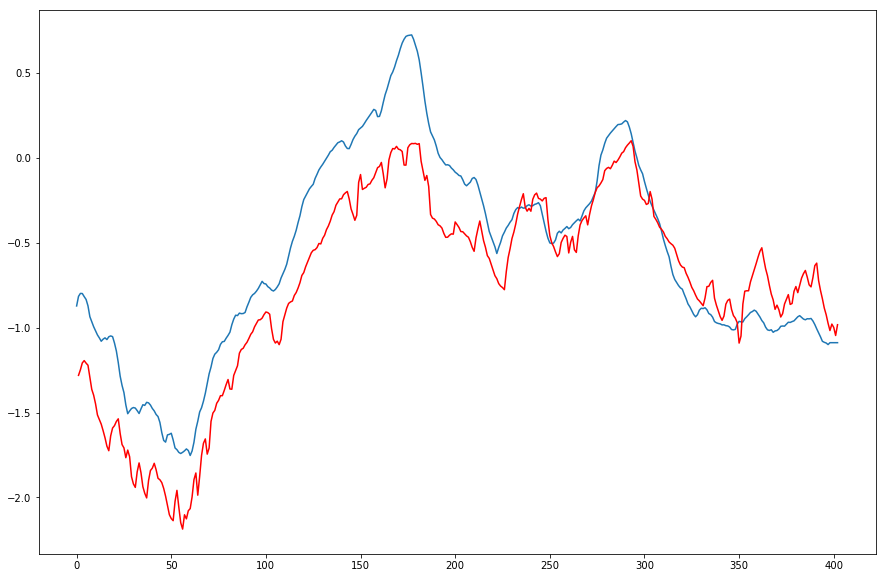

In [14]:
train_pr = lr.predict(trainx)
test_pr = lr.predict(testx)

#prepare test data for plotting
lr_pr_plot = np.concatenate((np.nan*np.ones(len(trainx)-600),test_pr))
plt.figure(figsize=(15,10))
plt.plot(df[600:,8])
plt.plot(lr_pr_plot, color='r')

## Random forest regressor

next, let us try a random forest regressor on the same data

In [8]:
rf = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=4,
                       bootstrap=True, n_jobs=-1, random_state=seed, verbose=1)
rf.fit(trainx, trainy)
rf.score(trainx, trainy)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.97825560530490441

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


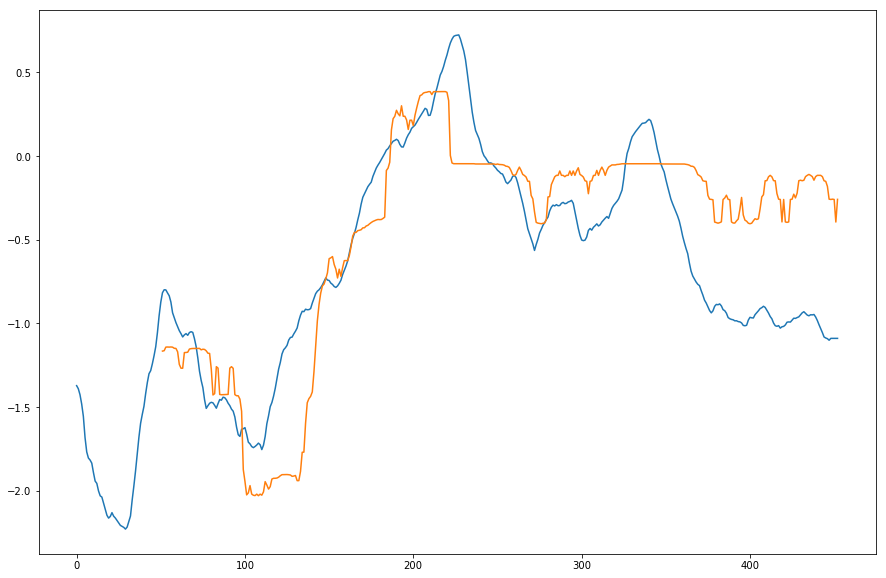

In [13]:
train_pr = rf.predict(trainx)
test_pr = rf.predict(testx)
test_pr_plot = np.concatenate((np.nan*np.ones(len(trainx)-550),test_pr))
plt.figure(figsize=(15,10))
plt.plot(df[550:,8])
#plt.plot(train_pr)
plt.plot(test_pr_plot)

In [13]:
rf.feature_importances_

array([  2.47771742e-05,   1.08317039e-03,   1.05127939e-03,
         6.91606813e-06,   1.67968149e-04,   2.79617520e-01,
         5.44519965e-01,   1.73528405e-01])

the linear nature of sklearn's regression forest leads to some underfitting. it is better than linear regression in its estimations on the peak, but largely under- and overestimates at the beginning and at the end of the period, respectively.

Feature importances tell us, that On Balance Volume, DJIA and Brent prices are the 3 most deceisive features, while other seem to be much less relevant.

## Random Forest Classifier

we can try to turn the problem into a classification task. Lets use a classification forest to predict if the DJIA price goes up or down after 4 days.

In [682]:
data['Yc'] = data['Y'] - data['High']

#0 means a decrease, 1 means an in crease in DJIA after 4 days
for i, item in enumerate(data['Yc']):
    if item < 0:
        data.ix[i,'Yc'] = 0
    elif i > 0:
        data.ix[i,'Yc'] = 1
    else: 
        data.ix[i,'Yc'] = 0
        
df['Yc'] = data['Yc'].values

df = df.dropna()

In [684]:
#creating train and test data, while preserving the ratio of the labels in the original data
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=seed)
x = df.ix[:,:9].values
y = df['Yc'].values
train_idx, test_idx = next(iter(sss.split(x, y)))
train_x, test_x = x[train_idx], x[test_idx]
train_y, test_y = y[train_idx], y[test_idx]

In [686]:
# a logictic regreesion to be used as a benchmark
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', tol=0.01, random_state=seed,
                        solver='newton-cg', max_iter=150, 
                       verbose=1, n_jobs=-1)

lr.fit(train_x, train_y)
lr.score(train_x, train_y)

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.0s finished


0.63694267515923564

In [691]:
#now, the same with the random forest classifier
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5,
                       bootstrap=True, n_jobs=-1, random_state=seed, verbose=1)
rf.fit(train_x, train_y)
rf.score(train_x, train_y)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


0.96178343949044587

In [692]:
rf.score(test_x, test_y)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


0.660377358490566

Although better than logistic, classification forest still does not do a good job. Practically, an accuracy of 0.6 is not enough.

## Neural Networks

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error
from keras.layers import LeakyReLU

Using TensorFlow backend.


In [16]:

trainx, testx = trainx.reshape(601,8,1), testx.reshape(402,8,1)

In [19]:
mlp = Sequential()
mlp.add(LSTM(5, input_shape = (8,1) ))


mlp.add(Dense(5, activation='relu'))



mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mean_squared_error', optimizer= 'sgd')
mlp.fit(trainx, trainy, epochs=70, batch_size=1, verbose=2)

Epoch 1/70
4s - loss: 0.6856
Epoch 2/70
3s - loss: 0.3568
Epoch 3/70
3s - loss: 0.2718
Epoch 4/70
3s - loss: 0.2179
Epoch 5/70
3s - loss: 0.1790
Epoch 6/70
3s - loss: 0.1495
Epoch 7/70
3s - loss: 0.1225
Epoch 8/70
3s - loss: 0.1018
Epoch 9/70
3s - loss: 0.0848
Epoch 10/70
3s - loss: 0.0761
Epoch 11/70
3s - loss: 0.0703
Epoch 12/70
3s - loss: 0.0665
Epoch 13/70
3s - loss: 0.0652
Epoch 14/70
3s - loss: 0.0650
Epoch 15/70
3s - loss: 0.0623
Epoch 16/70
3s - loss: 0.0616
Epoch 17/70
3s - loss: 0.0612
Epoch 18/70
3s - loss: 0.0600
Epoch 19/70
3s - loss: 0.0592
Epoch 20/70
3s - loss: 0.0582
Epoch 21/70
3s - loss: 0.0584
Epoch 22/70
3s - loss: 0.0576
Epoch 23/70
3s - loss: 0.0575
Epoch 24/70
3s - loss: 0.0563
Epoch 25/70
3s - loss: 0.0566
Epoch 26/70
3s - loss: 0.0557
Epoch 27/70
3s - loss: 0.0558
Epoch 28/70
3s - loss: 0.0553
Epoch 29/70
3s - loss: 0.0542
Epoch 30/70
3s - loss: 0.0536
Epoch 31/70
3s - loss: 0.0540
Epoch 32/70
3s - loss: 0.0534
Epoch 33/70
3s - loss: 0.0528
Epoch 34/70
3s - lo

In [ ]:
train_pr = mlp.predict(trainx).flatten()
test_pr = mlp.predict(testx).flatten()
#test_pr = scaler.inverse_transform(test_pr)
#train_pr = scaler.inverse_transform(train_pr)
test_pr_plot = np.concatenate((np.nan*np.ones(len(trainx)),test_pr), axis=0)
plt.figure(figsize=(15,10))
plt.plot((df[550:,8]))
#plt.plot(train_pr)
plt.plot(test_pr_plot)

In [127]:
test_pr.shape

(210, 1)

In [ ]:
from pyESN import ESN
esn = ESN(n_inputs = 6,
          n_outputs = 1,
          n_reservoir = 100,
          sparsity=0.05,
          noise=0.0002,
          spectral_radius = 0.000009,
          random_state=7,
          #teacher_forcing=True,
          silent=False)

pred_training = esn.fit(trainx, trainy)
prediction_test = esn.predict(testx)
prediction_train = esn.predict(trainx)
print("test error: \n"+str(np.sqrt(np.mean((prediction_test.flatten() - testy)**2))))

In [ ]:
plt.figure(figsize=(15,10))
train_pr = pred_training.flatten()
test_pr = prediction_test.flatten()

test_pr_plot = np.concatenate((np.nan*np.ones(len(trainx)),test_pr), axis=0)
plt.plot((df[:,6]))
plt.plot(train_pr)
plt.plot(test_pr_plot)